# Cross Stitch Patterns from Images - code development notebook

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by an x in the designated color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  A color count of stitches will also be reported so the relative amounts of different color threads can be determined.

Updated to Python 3.7 11-July-2019

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Load image file

In [2]:
from scipy.misc import imresize
import requests
from io import BytesIO

In [4]:
response = requests.get("http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg")
pic = plt.imread(BytesIO(response.content),format='jpg')
print(type(pic))

<class 'numpy.ndarray'>


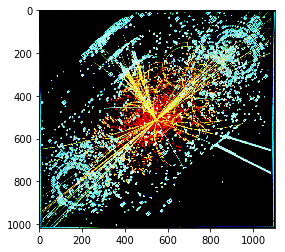

In [5]:
plt.imshow(pic);

In [7]:
print(pic.shape)
print(pic[100,100])

(1018, 1104, 3)
[0 0 0]


Cross-stitching is done with a material called "Aida Cloth".  The size of the weave is measured by how many stitches can be made in one inch. This is called the fabric's count. The most common counts in Aida Cloth are 11, 14, 18 and 28. The higher the number, the smaller the stitches will be, because there are more stitches in each inch. 

For a 20 inch by 20 inch picture, using 14 count Aida Cloth, you have 280 stitches by 280 stitches.  

If you want to reproduce a picture pixel for pixel, divide the number of pixels in a given dimension by the fabric count for the Aida Cloth you intend to use.  That will show you how large the resulting pattern will be.  e.g. for the Higgs event shown above, with 28 count Aida cloth, the image will be 39 x 36 inches - 3 feet by 3 feet.  

# Image adjustment

In [29]:
import scipy as sp
from sklearn import cluster
from sklearn.utils import shuffle


In [30]:
#Hmmm...imresize is deprecated and will be removed soon.  This will require more work.  JLK 11-July-2019

#resize image
def resize(image,scale=25):
    """scale = % to resize.  This seems to also convert the 0-1 colors to integer RGB"""
    return imresize(image,scale,mode="RGB")

In [11]:
#Kmeans algorithm to reduce number of colors
def reduce_colors(image, k):
    '''Apply kmeans algorithm.
   Input:  image, number of clusters to use
   Output: colors, counts per color, new image'''
    if k > 24:
        k = 24
        print("Setting colors to maximum allowed of 24")
    rows, cols, rgb = image.shape
    # reshape the image in a single row array of RGB pixels
    image_row = np.reshape(image,(rows * cols, 3))
    #HERE ADD CODE TO GET A GOOD GUESS OF COLORS AND PASS THAT AS
    #SECOND ARGUMENT TO kmeans
    # perform the clustering
    model = cluster.KMeans(n_clusters=k)
    # determine the pixel labels that most closely match each color                                                              
    labels = model.fit_predict(image_row)
    # this is the color palette, converted to integer RGB values                                                                 
    palette = model.cluster_centers_.astype(int)
    # assign the new colors to each pixel and reshape to match original image                                                    
    newimage = np.reshape(
        palette[labels], (rows, cols, palette.shape[1]))
    #count number of pixels of each cluster color                                                                                
    counts,bins = sp.histogram(newimage, len(palette))
    return palette, counts, newimage

#JLK: Look into providing an array of RGB values corresponding to 
#available floss and using those to determine the clustering

# Color/Floss counting

In [12]:
#count colors
def color_count(image):
    """Considering a (w,h,3) image of (dtype=uint8),
    compute the number of unique colors
    
    Encoding (i,j,k) into single index N = i+R*j+R*C*k
    Decoding N into (i,j,k) = (N−k*R*C−j*R, (N−k*R*C)/R, N/(R*C))
          using integer division
    \n"""
    #Need to convert image to uint32 before multiplication so numbers are not truncated
    F = uint32(image[...,0])*256*256 + uint32(image[...,1])*256 + uint32(image[...,2])
    unique, counts = np.unique(F, return_counts=True)
    colors = np.empty(shape=(len(unique),3),dtype=uint32)
    numcol = np.empty(len(unique),dtype=uint32)
    i = 0
    for col,num in zip(unique,counts):
        R = col//(256*256)
        G = (col-R*256*256)//256
        B = (col-R*256*256-G*256)
        colors[i] = (R,G,B)
        numcol[i] = num
        i+=1
    return colors, numcol


In [13]:
#Found an online RGB<-->DMC floss color conversion table to reference.
def load_floss_colors(example=True):
    values = np.loadtxt('DMCtoRGB_JLK.txt', delimiter=' , ',dtype=int, usecols=[0,2,3,4])
    labels = np.loadtxt('DMCtoRGB_JLK.txt', delimiter=' , ',dtype=str, usecols=[1,5])
    if example:
        print("Example: ",values[27],labels[27])
    return values,labels

In [14]:
#Use distance in RGB space to determine closest color match
def match_color(rgb,method="Euclidean"):
    """for a given r,g,b tuple, determine the closest DMC thread color"""
    values,labels = load_floss_colors(False)
    #Use color metric from http://www.compuphase.com/cmetric.htm
    rmean = (rgb[0]-values[:,1]) / 2.
    r = rgb[0]-values[:,1]
    g = rgb[1]-values[:,2]
    b = rgb[2]-values[:,3]
    match = np.sqrt(((2+rmean/256.)*r*r) + 4*g*g + (((2 + (255-rmean)/256.)*b*b)))
    #return values[match.argmin()],labels[match.argmin()]
             
    #Compute distance to nearest color in RGB space
    rdiff2 = (rgb[0]-values[:,1])**2
    gdiff2 = (rgb[1]-values[:,2])**2
    bdiff2 = (rgb[2]-values[:,3])**2
    cdiff = np.sqrt(rdiff2+gdiff2+bdiff2)
    #print("Input rgb: ",rgb,"\tClosest match:",values[cdiff.argmin()],labels[cdiff.argmin()])

    if method == "Euclidean":
        return values[cdiff.argmin()],labels[cdiff.argmin()]
    else:
        return values[match.argmin()],labels[match.argmin()]

In [15]:
def yardskeincount(counts,aidasize):
    """Given an array of stitch counts and an aida cloth
    size, calculate and return the number of skeins and yards of
    floss for each"""
    #floss length per stitch for given count aida cloth
    boxsize = 25.4/aidasize #mm
    #diagonal of box
    boxdiag = np.sqrt(2*boxsize**2)
    threadperstitch = 2*boxdiag + 2*boxsize
    threadperstitch *= 1.2 #increase by 20% to account for extras and gaps between stitches
    
    threadpercolor = counts*threadperstitch/1000. #number of meters of floss needed in each color
    #floss comes in skeins of 8.7 yards of 6-stranded thread.  Typical 14-count patterns take 2 strands
    flosslength = 3*8.7*0.9144 #convert yards of 6-stranded thread to meters of 2-stranded thread
    #yards of 6-stranded thread
    yardspercolor = threadpercolor*0.9144
    skeinspercolor = threadpercolor/flosslength # need to round up
    
    return yardspercolor,skeinspercolor

In [16]:
#Print and return the matched floss counts
def floss_color_counts(colors,counts,aidasize=14):
    '''print the matched floss colors and counts'''
    mycounts = counts.copy() #copy so we don't mess up the original arrays
    inds = mycounts.argsort()
    sortedcolors = colors[inds].copy() #copy so we don't mess up the original arrays
    mycounts.sort()
    
    yds,skeinspercolor = yardskeincount(mycounts,aidasize)
    
    #Create a list of skein color count, code, and name
    summary = []
    print("Counts\tRGBColor\tFloss#\tFlossRGB\t#Skeins\tFlossName")
    print("=====================================================================================")    
    for i in range(len(counts)-1,-1,-1):
        matches = match_color(sortedcolors[i])
        print(mycounts[i],"\t",sortedcolors[i],"\t",matches[0][0],"\t",matches[0][1:],"\t %.2f"%skeinspercolor[i],"\t",matches[1])
        summary.append((float("%.2f"%skeinspercolor[i]),matches[0][0],matches[1][0],(sortedcolors[i]),(matches[0][1:])))

    #Here condense any duplicates in the summary?
    
    return summary

In [17]:
#replace color at x,y coordinates (in pixel space) with floss color RGB to check the image fidelity
def replace_color(image,color,match):
    print(color,"\t--->\t",match)
    indices = np.where(np.all(image == color, axis=-1))
    #print image[indices[0],indices[1]]
    image[indices[0],indices[1]] = match
    #print image[indices[0],indices[1]]


# Utilities

In [18]:
#Print some useful pattern info
def aida_size(pic,aida=14):
    """Given an Aida cloth count and an image of a given number of pixels,
    report the size of the resulting pattern in inches"""
    y,x,col = pic.shape
    print("Pixel dimensions: (%d x %d)"%(x,y))
    print("Aida Cloth count: %d"%aida)
    print("Pattern dimensions: (%.2f in x %.2f in)"%(x/float(aida),y/float(aida)))
    print("Pattern colors: %d"%(color_count(pic)[1]).size)
    return x/float(aida), y/float(aida)

In [19]:
#Plot the image before and after manipulation
def plot_before_after(before,after,text="Transformed"):
    cb = color_count(before)[1].size
    ca = color_count(after)[1].size
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(1,2,figsize=(12, 6))
    axarr[0].imshow(before)
    axarr[0].set_title('Original image (%d colors)'%cb)
    axarr[1].set_title('%s image (%d colors)'%(text,ca))
    axarr[1].imshow(after);

# Applied to Data 

## Resize the image

/Users/jlklay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


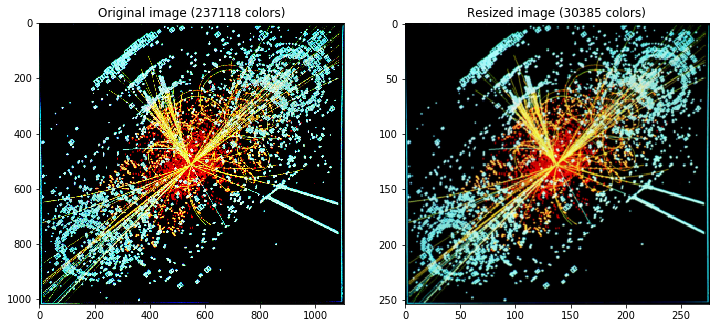

In [31]:
before = pic
smaller = resize(pic)
plot_before_after(before,smaller,"Resized")

---

# Apply color algorithm

In [38]:
#Takes a while.  We might try seeding the kmeans with decent guesses
colors, counts, after = reduce_colors(smaller, 32)

Setting colors to maximum allowed of 24


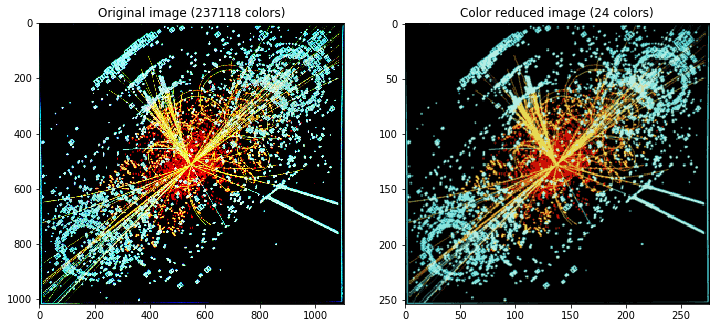

In [36]:
plot_before_after(before,after,"Color reduced")

# Show the results of the color match

In [39]:
#Counts of each color in RGB
summary = floss_color_counts(colors,counts)
#print summary

Counts	RGBColor	Floss#	FlossRGB	#Skeins	FlossName
123364 	 [0 0 0] 	 310 	 [0 0 0] 	 54.34 	 ['Black' '000000']
13561 	 [131  82  26] 	 975 	 [145  79  18] 	 5.97 	 ['Golden Brown Dk ' '914F12']
6817 	 [164 129  45] 	 782 	 [174 119  32] 	 3.00 	 ['Topaz Dark ' 'AE7720']
6810 	 [ 55 114 112] 	 3808 	 [ 54 105 112] 	 3.00 	 ['Turquoise Ult Vy Dk ' '366970']
6152 	 [211  95  26] 	 921 	 [198  98  24] 	 2.71 	 ['Copper ' 'C66218']
5993 	 [ 81 187 187] 	 959 	 [ 89 199 180] 	 2.64 	 ['Sea Green Med ' '59C7B4']
5616 	 [ 99 117  76] 	 367 	 [ 97 122  82] 	 2.47 	 ['Pistachio Green Dk ' '617A52']
4958 	 [134 191 176] 	 993 	 [144 192 180] 	 2.18 	 ['Aquamarine Vy Lt ' '90C0B4']
4650 	 [219 163  50] 	 3852 	 [205 157  55] 	 2.05 	 ['Straw Very Dark' 'CD9D37']
4429 	 [45 20  7] 	 3371 	 [30 17  8] 	 1.95 	 ['Black Brown ' '1E1108']
4046 	 [ 97 154 141] 	 3848 	 [ 85 147 146] 	 1.78 	 ['Teal Green Med ' '419392']
2745 	 [202  18   6] 	 817 	 [187   5  31] 	 1.21 	 ['Coral Red Very Dark' 'BB051F'

In [40]:
sizex,sizey = aida_size(after,aida=14)

Pixel dimensions: (276 x 254)
Aida Cloth count: 14
Pattern dimensions: (19.71 in x 18.14 in)
Pattern colors: 24


# Replace colors with matched floss colors 

Replacing image colors with matched floss color:
[0 0 0] 	--->	 [0 0 0]
[131  82  26] 	--->	 [145  79  18]
[164 129  45] 	--->	 [174 119  32]
[ 55 114 112] 	--->	 [ 54 105 112]
[211  95  26] 	--->	 [198  98  24]
[ 81 187 187] 	--->	 [ 89 199 180]
[ 99 117  76] 	--->	 [ 97 122  82]
[134 191 176] 	--->	 [144 192 180]
[219 163  50] 	--->	 [205 157  55]
[45 20  7] 	--->	 [30 17  8]
[ 97 154 141] 	--->	 [ 85 147 146]
[202  18   6] 	--->	 [187   5  31]
[175 172 109] 	--->	 [191 166 113]
[232 217  84] 	--->	 [253 215  85]
[206 220 168] 	--->	 [204 217 177]
[116 218 213] 	--->	 [144 195 204]
[119  12   5] 	--->	 [123   0  27]
[36 82 81] 	--->	 [ 28  80 102]
[75 65 21] 	--->	 [66 77 33]
[22 50 49] 	--->	 [23 73 35]
[188 239 226] 	--->	 [188 227 230]
[152 229 220] 	--->	 [169 226 216]
[ 49 145 151] 	--->	 [ 61 149 165]
[10 21 22] 	--->	 [30 17  8]


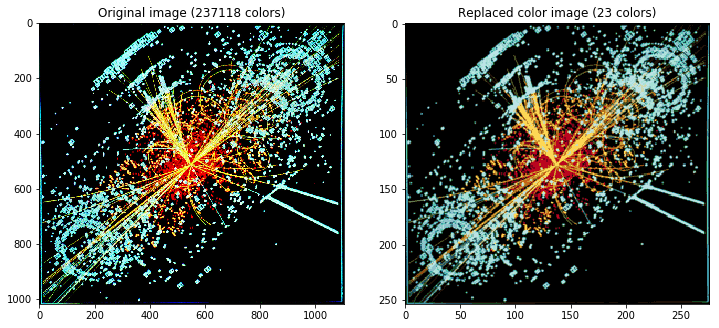

In [42]:
#Use a copy so we don't mess with the original reduced image
test = after.copy()
print("Replacing image colors with matched floss color:")
for (skeins, floss, name, oldcolor, matchedcolor) in summary:
    #print(skeins,"\t",name,"\t",floss)
    #print(matchedcolor)
    replace_color(test,oldcolor,matchedcolor)

plot_before_after(before,test,"Replaced color")

In [43]:
finalunique, finalcount = color_count(test)

In [44]:
import random
symb = ['A','C','E','H','K','L','N','O','R','S','T','U','V','W','X','Y','Z',
        '1','2','3','4','5','7','8','9','-','+','=','/','*','(',')','<','>']

symb2 = [u'\u0023',u'\u0024',u'\u0025',u'\u002B',u'\u002F',u'\u0030',u'\u003c',u'\u003D',u'\u003E',u'\u0041',u'\u0048',
        u'\u0049',u'\u004B',u'\u004C',u'\u004E',u'\u0053',u'\u0054',u'\u0056',u'\u0058',u'\u005A',u'\u005C',u'\u005E',
        u'\u007C',u'\u007E',u'\u00B1',u'\u0394',u'\u039B',u'\u0393',u'\u03C0',u'\u03BB',u'\u03C9',u'\u2015',u'\u221E',
        u'\u2248',u'\u2297',u'\u2229',u'\u222A',u'\u25A1',u'\u25B2',u'\u25CB']

def symbol_dictionary(colors):
    symbols = []
    collist = []
    #Shuffle the symbols
    random.shuffle(symb,random.random)
    for i in range(len(colors)):
        if np.all(colors[i] == (0, 0, 0)):
            symbols.append('.')
            collist.append((0,0,0))
        else:
            symbols.append(symb[i])
            collist.append((colors[i][0],colors[i][1],colors[i][2]))
    return dict(zip(collist,symbols))

In [46]:
colsymb = symbol_dictionary(finalunique)
print(colsymb)

{(0, 0, 0): '.', (23, 73, 35): 'N', (28, 80, 102): '7', (30, 17, 8): '+', (54, 105, 112): 'E', (61, 149, 165): '(', (66, 77, 33): ')', (85, 147, 146): 'V', (89, 199, 180): '5', (97, 122, 82): '9', (123, 0, 27): 'X', (144, 192, 180): 'Y', (144, 195, 204): 'U', (145, 79, 18): 'S', (169, 226, 216): '3', (174, 119, 32): '=', (187, 5, 31): '*', (188, 227, 230): '/', (191, 166, 113): '4', (198, 98, 24): '-', (204, 217, 177): 'K', (205, 157, 55): 'C', (253, 215, 85): '2'}


In [47]:
pattern_name = "Higgs Boson Event"
designer_name = "StitchIt"
aidacolor = 'black'

In [49]:
def color_dictionary(after,aidasize=14):
    colors,counts=color_count(after)
    yards,skeins = yardskeincount(counts,aidasize)
    values,labels = load_floss_colors(False)
    
    plt.figure(27,figsize=(7.5,10.))
    ax = plt.axes([0.025, 0.025, 0.95, 0.95],frameon=False)
    ax.set_xlim(0,1) 
    ax.set_ylim(0,1)
    plt.text(0.1,0.9,"Pattern Name:",fontweight='bold')
    plt.text(0.28,0.9,"%s"%pattern_name)
    plt.text(0.1,0.87,"Stitches:",fontweight='bold')
    plt.text(0.28,0.87,"%dw x %dh"%(after.shape[1],after.shape[0]))
    plt.text(0.28,0.85,"(2 strands, full)")
    plt.text(0.55,0.9,"Finished Size:",fontweight='bold')
    plt.text(0.73,0.9,"%.1f\"w x %.1f\"h "%(sizex,sizey))
    plt.text(0.55,0.87,"Fabric:",fontweight='bold')
    plt.text(0.73,0.87,"%s-ct %s aida"%(aidasize,aidacolor))
    plt.text(0.1,0.78,"DMC")
    plt.text(0.25,0.78,"Symbol")
    plt.text(0.4,0.78,"Color")
    plt.text(0.52,0.78,"Yards")
    plt.text(0.65,0.78,"Description")
    plt.plot((0.08,0.9),(0.775,0.775),"k")
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.text(0.25,0.02,"$\copyright$ 2019 StitchIt - https://github.com/dedx/StitchIt")
    yspace = 0.03
    i = 1
    colsymb = symbol_dictionary(colors)
    for col,yc,sc in zip(colors,yards,skeins):
        #Find the index where color appears in the floss list
        index = np.where(np.all(values[:,1:] == col, axis=-1))
        plt.text(0.1,0.78-i*yspace,"%d"%values[index[0],0][0],ha='left')
        if (np.all(col == (0,0,0))):
            plt.plot(0.28,0.785-i*yspace,marker='.',color='k')
        else:
            #plt.text(0.278,0.78-i*yspace+0.003, colsymb[(col[0],col[1],col[2])], fontname='STIXGeneral',size=12, va='center', ha='center', clip_on=True)
            plt.plot(0.278,0.78-i*yspace+0.003,marker="$\mathrm{\mathsf{%s}}$"%colsymb[(col[0],col[1],col[2])],markersize=8,color='k')
        #plt.plot(0.282,0.78-(i-0.1)*yspace+0.0025, 's',markersize=10,markerfacecolor='None')
        plt.plot(0.425,0.78-(i-0.1)*yspace+0.0025, 's',markersize=10,markerfacecolor=(col[0]/255.,col[1]/255.,col[2]/255.),markeredgecolor='k')
        plt.text(0.56,0.78-i*yspace,"%.0f"%np.ceil(yc),ha='right')
        plt.text(0.65,0.78-i*yspace,"%s"%labels[index[0],0][0])
        
        i += 1
        
    return colsymb

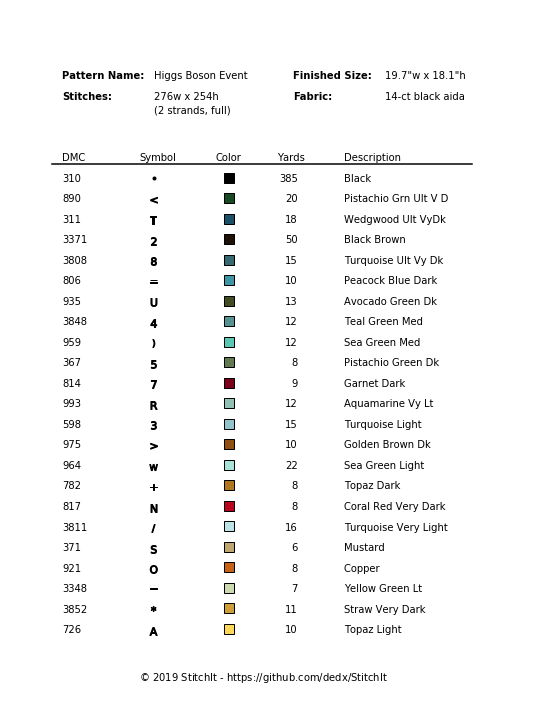

In [50]:
colsymb = color_dictionary(test)

## Hmmmm....

Much better color match with new DMC RGB mapping.

In [51]:
def view_colors(summary):
    vals,labs = load_floss_colors(example=False)
    fig = plt.figure(1,figsize=(15,15))
    plt.axes()

    count = 0
    #Plot original and matched colors
    for (skeins, floss, name, oldcolor, matchedcolor) in summary:
        circle = plt.Circle((count, 26), radius=0.5, fc=(oldcolor[0]/255.,oldcolor[1]/255.,oldcolor[2]/255.));
        plt.gca().add_patch(circle)
        plt.plot([-2,27],[25.5,25.5],"k")
        circle2 = plt.Circle((count, 25), radius=0.5, fc=(matchedcolor[0]/255.,matchedcolor[1]/255.,matchedcolor[2]/255.));
        plt.gca().add_patch(circle2)
        plt.text(count,24,floss,va='center', ha='center',fontsize=10)
        count += 1

    plt.text(17,25.75,"Original Colors",fontsize=15)
    plt.text(17,24.75,"Matched Floss",fontsize=15)
    plt.text(-6,22,"DMC Flosses:",fontsize=15)
    
    #Plot available floss colors
    for i in range(len(vals)):
        row=i/20
        col=i%20
        circle = plt.Circle((col, row), radius=0.5, fc=(vals[i,1]/255.,vals[i,2]/255.,vals[i,3]/255.));
        plt.gca().add_patch(circle)
        plt.text(col,row,vals[i,0],va='center', ha='center',fontsize=10)
        plt.axis('scaled')
    plt.xlim(-2,22)
    plt.ylim(-2,27)
    plt.show()

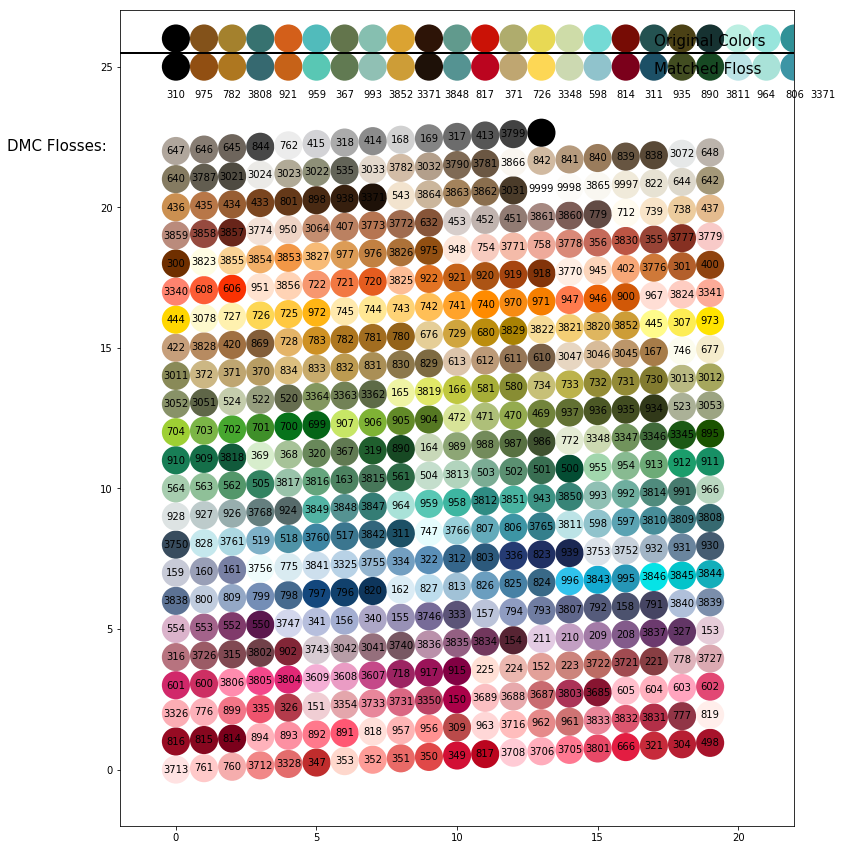

In [52]:
view_colors(summary)

---

# Create pattern

Now that the size and colors have been reduced, represent each color by a character and plot those characters on a 2-D grid representing the image.

In [53]:
#retrieve x,y coordinates (in pixel space) of all pixels of a given color
def locate_color(image,color):
    indices = np.where(np.all(image == color, axis=-1))
    #print zip(indices[0], indices[1])
    return indices[1], indices[0] #row,col vs. x,y

In [54]:
#Figure out how to parse it into 8.5x11 paper
#each paper has 7.5 inches of width to work with and 10 inches of height

wp,hp = 7.5,10. #printable paper width,height
cmperinch = 2.54 #cm
print("Printable width: %.2f cm"%(wp*cmperinch)) #convert paper-width to cm
print("Printable height: %.2f cm"%(hp*cmperinch)) #convert paper-height to cm

boxespercm = 4 # 0.25mm per side
numpix_x = int(np.floor(wp*cmperinch*boxespercm))
numpix_y = int(np.floor(hp*cmperinch*boxespercm))
print("Pixels in x: %d"%numpix_x)
print("Pixels in y: %d"%numpix_y)

Printable width: 19.05 cm
Printable height: 25.40 cm
Pixels in x: 76
Pixels in y: 101


Given the numbers, let's round to 80x100 grid boxes with a border of 10

Portrait:
xdim: 276 pixels / 80 pxperpg = 4 pages
ydim: 254 pixels / 100 pxperpg = 3 pages
[[70 80 80 46]
 [70 80 80 46]
 [70 80 80 46]] 
 276
[[ 90  90  90  90]
 [100 100 100 100]
 [ 64  64  64  64]] 
 254


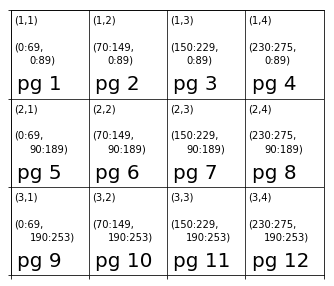

In [56]:
#How many pieces of paper do we need?
gridx = 80 #max px in x direction
gridy = 100 #max px in y direction
border = 10 #grid box border
pgsx = int(np.ceil(after.shape[1]/float(gridx)))
pgsy = int(np.ceil(after.shape[0]/float(gridy)))

print("Portrait:")
print("xdim: %d pixels / %d pxperpg = %d pages"%(after.shape[1],gridx,pgsx))
print("ydim: %d pixels / %d pxperpg = %d pages"%(after.shape[0],gridy,pgsy))

pxperpg_x = np.zeros([pgsy, pgsx],dtype=int)+80
pxperpg_y = np.zeros([pgsy, pgsx],dtype=int)+100
#leftmost pages have 70 px in x, next n have 80 each, rightmost have remainder
#topmost pages have 90 px in x, next n have 100 each, bottommost have remainder
pxperpg_x[:,0] -= 10; pxperpg_x[:,-1] = after.shape[1]-pxperpg_x[0,0:-1].sum()
pxperpg_y[0,:] -= 10; pxperpg_y[-1,:] = after.shape[0]-pxperpg_y[0:-1,0].sum()
print(pxperpg_x,"\n",pxperpg_x[0].sum())
print(pxperpg_y,"\n",pxperpg_y[:,0].sum())

plt.figure(27,figsize=(4*sizex/sizey,4*sizey/sizex))
ax = plt.axes([0,0,1,1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.xaxis.set_major_locator(plt.MultipleLocator(1/4.))
ax.yaxis.set_major_locator(plt.MultipleLocator(1/3.))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='k')
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='k')

page = 0
for row in range(pgsy):
    for col in range(pgsx):
        x = col/float(pgsx)+0.01
        y = 0.95-row/float(pgsy)
        pxmin = pxperpg_x[row,:col].sum()
        pxmax = pxperpg_x[row,:col].sum()+pxperpg_x[row,col]-1
        pymin = pxperpg_y[:row,col].sum()
        pymax = pxperpg_y[:row,col].sum()+pxperpg_y[row,col]-1
        ax.text(x,y,"(%d,%d)"%(row+1,col+1))
        page += 1
        ax.text(x+0.01,y-0.25,"pg %d"%page,fontsize=20)
        ax.text(x,y-0.1,"(%d:%d,"%(pxmin,pxmax))
        ax.text(x+0.05,y-0.15,"%d:%d)"%(pymin,pymax))

70 149 90 189
pxperpg_y[:row,col].sum() 164
154


(0, 254)

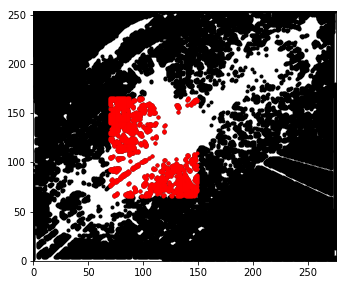

In [59]:
#Visualize the different pages of the pattern
row = 1; col = 1
ymax = after.shape[0]
pxmin = pxperpg_x[row,:col].sum()
pxmax = pxperpg_x[row,:col].sum()+pxperpg_x[row,col]-1
pymin = pxperpg_y[:row,col].sum()
pymax = pxperpg_y[:row,col].sum()+pxperpg_y[row,col]-1
rowmin = pymin; rowmax = pymax
colmin = pxmin; colmax = pxmax
print(pxmin,pxmax,pymin,pymax)
print("pxperpg_y[:row,col].sum()",pxperpg_y[row:,col].sum())
print(ymax-pxperpg_y[row,col])
fig = figure(5,figsize=(5*sizex/sizey,5*sizey/sizex))

x,y = locate_color(after,(0,0,0))
plt.plot(x,ymax-y+1,'k.')


x2,y2 = locate_color(after[rowmin:rowmax+1,colmin:colmax+1,...],(0,0,0))
plt.plot(x2+pxmin,ymax-y2-pymin+1,'r.')

plt.xlim(0,276)
plt.ylim(0,254)


In [60]:
def cover_page(before,after,aidasize=14):
    cb = color_count(before)[1].size
    ca = color_count(after)[1].size
    # Two subplots, the axes array is 1-d
    plt.figure(0,figsize=(7.5,10.))
    ax1 = plt.subplot2grid((3,2), (0,0), colspan=2,frameon=False)
    ax2 = plt.subplot2grid((3,2), (1,0))
    ax3 = plt.subplot2grid((3,2), (1,1))
    ax4 = plt.subplot2grid((3,2), (2,0), colspan=2,frameon=False)
    ax1.set_xlim(0,1)
    ax1.set_ylim(0.5,1)
    ax1.text(0.475,0.85,"Pattern Name:",fontweight='bold',fontsize=15,ha='right')
    ax1.text(0.525,0.85,"%s"%pattern_name,fontsize=15)
    ax1.text(0.475,0.75,"Stitches:",fontweight='bold',ha='right')
    ax1.text(0.525,0.75,"%dw x %dh (2 strands, full)"%(after.shape[1],after.shape[0]))
    ax1.text(0.475,0.7,"Finished Size:",fontweight='bold',ha='right')
    ax1.text(0.525,0.7,"%.1f\" w x %.1f\" h "%(sizex,sizey))
    ax1.text(0.475,0.65,"Fabric:",fontweight='bold',ha='right')
    ax1.text(0.525,0.65,"%s-ct %s aida"%(aidasize,aidacolor))
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    
    ax2.imshow(before);
    ax2.set_title('Original image (%d colors)'%cb);
    ax2.set_xlabel("%d x %d pixels"%(before.shape[1],before.shape[0]))
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    
    ax3.set_title('Transformed image (%d colors)'%ca);
    ax3.set_xlabel("%d x %d pixels"%(after.shape[1],after.shape[0]))
    ax3.imshow(after);
    ax3.set_xticklabels([])
    ax3.set_xticks([])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    
    ax4.set_xlim(0,1)
    ax4.set_ylim(0,1)
    ax4.text(0.5,0.5,"$\copyright$ 2019 StitchIt - https://github.com/dedx/StitchIt",fontsize=15,ha='center')
    
    ax4.set_xticklabels([])
    ax4.set_xticks([])
    ax4.set_yticklabels([])
    ax4.set_yticks([])
    
    

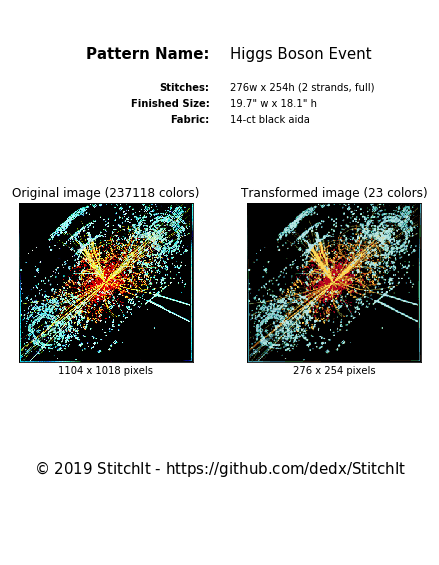

In [61]:
cover_page(before,test)

In [62]:
import datetime
from matplotlib.backends.backend_pdf import PdfPages

In [63]:
def make_pattern(before,after):
    wp,hp = 7.5,10. #printable paper width,height
    cmperinch = 2.54 #cm
    boxespercm = 4 # 0.25mm per side
    numpix_x = int(np.floor(wp*cmperinch*boxespercm))
    numpix_y = int(np.floor(hp*cmperinch*boxespercm))
    gridx = 80 #max px in x direction
    gridy = 100 #max px in y direction
    border = 10 #grid box border
    xmax = after.shape[1]
    ymax = after.shape[0]
    pgsx = int(np.ceil(xmax/float(gridx)))
    pgsy = int(np.ceil(ymax/float(gridy)))
    pxperpg_x = np.zeros([pgsy, pgsx],dtype=int)+80
    pxperpg_y = np.zeros([pgsy, pgsx],dtype=int)+100
    #leftmost pages have 70 px in x, next n have 80 each, rightmost have remainder
    #topmost pages have 90 px in x, next n have 100 each, bottommost have remainder
    pxperpg_x[:,0] -= 10; pxperpg_x[:,-1] = xmax-pxperpg_x[0,0:-1].sum()
    pxperpg_y[0,:] -= 10; pxperpg_y[-1,:] = ymax-pxperpg_y[0:-1,0].sum()  

    finalunique, finalcount = color_count(after)
    
    #http://matplotlib.org/examples/pylab_examples/multipage_pdf.html
    # Create the PdfPages object to which we will save the pages:
    # The with statement makes sure that the PdfPages object is closed properly at
    # the end of the block, even if an Exception occurs.
    with PdfPages('Pattern.pdf') as pdf:
        cover_page(before,test)
        pdf.savefig(papertype='letter',bbox_inches='tight')
        print("Adding Cover page")
        plt.close()
        page = 0
        colsymb = color_dictionary(after)
        pdf.savefig(papertype='letter',bbox_inches='tight')
        print("Adding page %d"%page)
        plt.close()
        for row in range(pgsy): #row=y
            for col in range(pgsx): #col=x
                page += 1
                pxmin = pxperpg_x[row,:col].sum()
                pxmax = pxperpg_x[row,:col].sum()+pxperpg_x[row,col]-1
                pymin = pxperpg_y[:row,col].sum()
                pymax = pxperpg_y[:row,col].sum()+pxperpg_y[row,col]-1

                rowmin = pymin; rowmax = pymax
                colmin = pxmin; colmax = pxmax
                pltxmin = pxmin; pltxmax = pxmax
                pltymin = pymax; pltymax = pymin
                if col == 0:
                    pltxmin -= border
                if row == 0: 
                    pltymax -= border
                if col == pgsx-1:
                    pltxmax = gridx*pgsx
                if row == pgsy-1:
                    pltymin = gridy*pgsy
    
                plt.figure(row,figsize=(wp,hp))
                ax = plt.axes([0.025, 0.025, 0.95, 0.95])
                ax.set_xlim(pltxmin,pltxmax) #Row,Col vs. x,y
                ax.set_ylim(pltymin,pltymax) #with padding around image
                ax.xaxis.set_major_locator(plt.MultipleLocator(10.))
                ax.xaxis.set_minor_locator(plt.MultipleLocator(1.))
                ax.yaxis.set_major_locator(plt.MultipleLocator(10.))
                ax.yaxis.set_minor_locator(plt.MultipleLocator(1.))
                ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')
                ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')
                ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
                ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
                #ax.set_xticklabels([])
                #ax.set_yticklabels([])
                for color in colsymb:
                    if (np.all(color) == 0):
                        x,y = locate_color(after[rowmin:rowmax+1,colmin:colmax+1,...],color)
                        #Use small dot for black pixels
                        plt.plot(x+pxmin+0.5,y+pymin+0.5, color='k',marker='.', lw = 0,markersize=2)
                    else:
                        x,y = locate_color(after[rowmin:rowmax+1,colmin:colmax+1,...],color)
                        #plt.text(x+pxmin+0.5,y+pymin+0.5, colsymb[color], fontname='STIXGeneral',size=12, va='center', ha='center', clip_on=True)
                        plt.plot(x+pxmin+0.5,y+pymin+0.5, marker="$\mathrm{\mathsf{%s}}$" % colsymb[color], markersize=4,color='k',lw = 0,markeredgecolor=None)
    
                ax.text(pltxmin+40,pltymin+4,"$\copyright$ 2019 StitchIt - https://github.com/dedx/StitchIt")
                ax.text(pltxmin,pltymin+4,"(%d,%d) pg %d of %d"%(row,col,page,pgsx*pgsy))
                pdf.savefig(papertype='letter',bbox_inches='tight')
                print("Adding page %d"%page)
                plt.close()
                
                # We can also set the file's metadata via the PdfPages object:
                d = pdf.infodict()
                d['Title'] = 'Stitchit Pattern'
                d['Author'] = 'Jennifer Klay'
                d['Subject'] = 'Multi-page cross-stitch pattern file'
                d['Keywords'] = 'PdfPages multipage keywords author title subject'
                d['CreationDate'] = datetime.datetime(2019, 7, 11)
                d['ModDate'] = datetime.datetime.today()

In [64]:
#Note: Need to pass the replaced color image and a revised "summary" with the new colors in it.
make_pattern(before,test)

Adding Cover page
Adding page 0
Adding page 1
Adding page 2
Adding page 3
Adding page 4
Adding page 5
Adding page 6
Adding page 7
Adding page 8
Adding page 9
Adding page 10
Adding page 11
Adding page 12


# To-Dos:

1. Figure out how to provide the floss color dictionary to the K-means algorithm for semi-supervised clustering.
2. Have it deal with background color better - if fabric is black or white, treat black or white specially?